## Imports

In [186]:
import pandas as pd

## Data

In [216]:
df_test = pd.read_pickle("../data/interim/Test_extern_git_feat.pickle")

In [217]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [218]:
modes = df_train.click_mode.unique()
modes.sort()
modes

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [223]:
df_train[df_train.click_mode == 0].sid[:10]

27     2554010
59      951150
61     2269001
68     2514442
70      315512
80     2085587
92     2030327
97      933711
99     3027090
109    1212178
Name: sid, dtype: int64

In [189]:
df_train.click_mode = df_train.click_mode -1 

In [191]:
modes = df_train.click_mode.unique()
modes.sort()
modes

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [60]:
df_train.head()

,o1,o2,d1,d2,mode_feas_0,mode_feas_1,mode_feas_2,mode_feas_3,mode_feas_4,mode_feas_5,...,svd_fea_17_2,svd_fea_18_2,svd_fea_19_2,Response_2,dy,dyq,q,qdy,xq,xydy
0,116.29,39.97,116.32,39.96,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,-0.000000,-0.000000,9.0,0,0,1,0,0,0
1,116.39,39.84,116.33,39.79,0.0,1.0,0.0,1.0,1.0,0.0,...,0.879959,0.022791,-0.246445,1.0,0,0,1,0,0,0
2,116.31,39.93,116.27,40.00,0.0,0.0,1.0,1.0,1.0,0.0,...,0.000000,-0.000000,-0.000000,9.0,0,0,1,0,0,0
3,116.27,39.88,116.39,39.90,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.082645,-0.121038,-0.334641,1.0,1,0,0,0,0,0
4,116.34,39.96,116.37,39.86,0.0,0.0,0.0,1.0,1.0,0.0,...,0.831827,0.082881,-0.049859,7.0,0,0,1,0,0,0


In [61]:
df_train = df_train.drop(['click_time', 'req_time', 'plan_time', 'req_date', 'weather',
                         'Response', 'Response_2'], axis=1)

In [42]:
test_X = df_test.drop(['req_time', 'plan_time', 'req_date', 'weather'], axis=1)

In [90]:
df_train = df_train.drop(['click_time', 'req_time', 'plan_time', 'req_date', 'weather',
                         'Response', 'Response_2'], axis=1)
train_X = df_train.drop("click_mode", axis=1).values
train_y = df_train['click_mode'].values   

test_X = df_test.drop(['req_time', 'plan_time', 'req_date', 'weather'], axis=1).values

In [91]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)

(500000, 212)
(500000,)
(94358, 212)


## Functions

In [62]:
def f1_weighted(labels, preds):
    from sklearn.metrics import f1_score
    import numpy as np
    print(preds.shape)
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [63]:
def test_train_split_df(df_r, test_percentage=0.25):
    import numpy as np
    df = df_r.copy()
    
    msk = np.random.rand(len(df)) < (1-test_percentage)
    
    train = df[msk]
    val = df[~msk]
    
    train_X = train.drop("click_mode", axis=1).values
    train_y = train['click_mode'].values
    
    val_X = val.drop("click_mode", axis=1).values
    val_y = val['click_mode'].values
    
    return train_X, train_y, val_X, val_y
    

In [177]:
def train_lgb(train_x, train_y, test_x):
    import numpy as np

    import lightgbm as lgb


    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score
    from time import gmtime, strftime

    import pandas as pd

    print('Train LGB')
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate': 0.05,
        'num_leaves': 60,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 12,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4
    }
    count = 1
    scores = []
    result_proba = []
    for tr_idx, val_idx in kfold.split(train_x, train_y):
        print('Split Nr: ', count)
        # Take one split
        tr_x, tr_y, val_x, val_y = train_x[tr_idx], train_y[tr_idx], train_x[val_idx], train_y[val_idx]
        train_set = lgb.Dataset(tr_x, tr_y)
        val_set = lgb.Dataset(val_x, val_y)
        # Train on this split
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=50,
                              num_boost_round=40000, verbose_eval=50, feval=eval_f)
        
        # Predict on best iteration of this split with validation set
        val_pred = np.argmax(lgb_model.predict(
            val_x, num_iteration=lgb_model.best_iteration), axis=1)
        
        # F1 val score
        val_score = f1_score(val_y, val_pred, average='weighted')
        
        # Predict with test set on best iteration of this split
        result_proba.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)
    
    lgb_model.predict
    
    return pred_test

In [247]:
def train_lgb_11(train_x, train_y, test_x):
    import numpy as np

    import lightgbm as lgb


    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score
    from time import gmtime, strftime

    import pandas as pd

    print('Train LGB')
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate': 0.05,
        'num_leaves': 60,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 11,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4
    }
    count = 1
    scores = []
    result_proba = []
    for tr_idx, val_idx in kfold.split(train_x, train_y):
        print('Split Nr: ', count)
        # Take one split
        tr_x, tr_y, val_x, val_y = train_x[tr_idx], train_y[tr_idx], train_x[val_idx], train_y[val_idx]
        train_set = lgb.Dataset(tr_x, tr_y)
        val_set = lgb.Dataset(val_x, val_y)
        # Train on this split
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=50,
                              num_boost_round=40000, verbose_eval=50, feval=eval_f_11)
        
        # Predict on best iteration of this split with validation set
        val_pred = np.argmax(lgb_model.predict(
            val_x, num_iteration=lgb_model.best_iteration), axis=1)
        
        # F1 val score
        val_score = f1_score(val_y, val_pred, average='weighted')
        
        # Predict with test set on best iteration of this split
        result_proba.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)
    
    lgb_model.predict
    
    return pred_test

In [85]:
def eval_f(y_pred, train_data):
    y_true = train_data.label
    y_pred = y_pred.reshape((12, -1)).T
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average='weighted')
    return 'weighted-f1-score', score, True

In [246]:
def eval_f_11(y_pred, train_data):
    y_true = train_data.label
    y_pred = y_pred.reshape((11, -1)).T
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average='weighted')
    return 'weighted-f1-score', score, True

In [97]:
def submit_result(submit, result, model_name):
    now_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

    submit['recommend_mode'] = result
    submit.to_csv(
        './{}_result_{}.csv'.format(model_name, now_time), index=False)

In [742]:
def plot_count_mode(df, title):
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(20,10))
    x = df.click_mode.unique()
    x.sort()
    y = df.groupby('click_mode').count()['sid']
    ax.bar(x, y);
    ax.set_xticklabels(x, fontsize=16);
    ax.set_xticks(x);
    ax.set_yticklabels(range(0,90000,10000), fontsize=16);
    rects = ax.patches

    # Make some labels.
    labels = y

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, '{:.2f}'.format(label),
                ha='center', va='bottom', fontsize=16)

    ax.set_title(title, fontsize=16);
    return fig

In [95]:
df_preds = train_lgb(train_X, train_y, test_X)

Train LGB
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.02429	valid_0's weighted-f1-score: 0.675711
[100]	valid_0's multi_logloss: 0.914775	valid_0's weighted-f1-score: 0.679062
[150]	valid_0's multi_logloss: 0.890035	valid_0's weighted-f1-score: 0.680325
[200]	valid_0's multi_logloss: 0.882807	valid_0's weighted-f1-score: 0.681198
[250]	valid_0's multi_logloss: 0.880301	valid_0's weighted-f1-score: 0.681231
Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.881229	valid_0's weighted-f1-score: 0.681382
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.02012	valid_0's weighted-f1-score: 0.676743
[100]	valid_0's multi_logloss: 0.910431	valid_0's weighted-f1-score: 0.679554
[150]	valid_0's multi_logloss: 0.885687	valid_0's weighted-f1-score: 0.680928
[200]	valid_0's multi_logloss: 0.878107	valid_0's weighted-f1-score: 0.681646
[250]	valid_0's multi_logloss: 0.875517	valid_0's weigh

In [96]:
df_preds

array([2, 1, 7, ..., 7, 9, 7])

In [98]:
submit = pd.read_pickle("../data/interim/submit.pickle")

In [100]:
submit_result(submit, df_preds, "lgb")

In [101]:
!ls

0.1_AV_understand_data.ipynb		  0.5_AV_BaselineLightGBM.ipynb
0.1_FL_Create_Test_Train_Split.py	  1_AB_EDA.ipynb
0.1_FL_Data_to_Multiclass_PreProcess.py   2_AB_time_features.ipynb
0.1_FL_add_features_to_multiclass_DFs.py  3_AB_subways.ipynb
0.1_FL_multivariate_models_fitting.py	  4_AB_weather.ipynb
0.1_SVM_Multiclass_Approach.py		  5_AB_raw_preprocessing.ipynb
0.1_TF_Ranking_Basic_Intro.py		  6_AB_check_raw_processed.ipynb
0.2_AV_LearningToRankExample.ipynb	  81_AV_tf_basline_multiclass.ipynb
0.2_FL_multivariate_models_fitting.py	  lgb_result_2019-05-27-10-04-33.csv
0.4_AV_Preprocessing_Script.ipynb


## With downsampled 2

In [162]:
df_downsampled = pd.read_pickle('../data/interim/df_train_downsampled_2.pickle')

In [163]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [164]:
df_downsampled.head()

,sid,click_time,click_mode,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query,...,req_hour,req_weekend,req_night,req_day,req_evening,is_holiday,max_temp,min_temp,weather,wind
258683,3243304.0,2018-11-25 08:11:44,2.0,199018.0,2018-11-25 08:11:41,116.28,40.15,116.32,39.89,0.263059,...,8,0,0,1,0,0,10,-3,q,1
264389,1926430.0,2018-11-13 08:42:42,2.0,131859.0,2018-11-13 08:42:38,116.35,39.94,116.41,39.91,0.067082,...,8,0,0,1,0,0,13,5,dy,12
270129,2028357.0,2018-10-14 20:26:19,2.0,206961.0,2018-10-14 20:26:02,116.53,39.85,116.49,39.87,0.044721,...,20,0,0,0,1,0,21,10,dy,12
235758,3209336.0,2018-11-07 13:48:10,2.0,118577.0,2018-11-07 13:48:03,116.52,39.91,116.34,39.97,0.189737,...,13,0,0,1,0,0,13,3,dy,12
402736,3389786.0,2018-11-24 12:06:27,2.0,209627.0,2018-11-24 11:56:19,116.40,40.06,116.33,39.99,0.098995,...,11,1,0,1,0,0,9,-3,qdy,2


In [166]:
df_downsampled = df_downsampled.sid
df_train = df_train.loc[df_train['sid'].isin(df_merged.values)]


In [167]:
df_train = df_train.drop(['click_time', 'req_time', 'plan_time', 'req_date', 'weather',
                         'Response', 'Response_2'], axis=1)
train_X = df_train.drop("click_mode", axis=1).values
train_y = df_train['click_mode'].values   

test_X = df_test.drop(['req_time', 'plan_time', 'req_date', 'weather'], axis=1).values

In [168]:
df_preds = train_lgb(train_X, train_y, test_X)

Train LGB
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.922253	valid_0's weighted-f1-score: 0.703692
[100]	valid_0's multi_logloss: 0.809932	valid_0's weighted-f1-score: 0.705907
[150]	valid_0's multi_logloss: 0.784896	valid_0's weighted-f1-score: 0.707259
[200]	valid_0's multi_logloss: 0.77753	valid_0's weighted-f1-score: 0.708233
[250]	valid_0's multi_logloss: 0.774987	valid_0's weighted-f1-score: 0.708512
[300]	valid_0's multi_logloss: 0.774002	valid_0's weighted-f1-score: 0.708705
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.774695	valid_0's weighted-f1-score: 0.708939
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.920349	valid_0's weighted-f1-score: 0.70304
[100]	valid_0's multi_logloss: 0.807929	valid_0's weighted-f1-score: 0.70488
[150]	valid_0's multi_logloss: 0.78263	valid_0's weighted-f1-score: 0.706754
[200]	valid_0's multi_logloss: 0.775269	valid_0's weighte

In [169]:
submit_result(submit, df_preds, 'lgb_downsampled')

In [175]:
modes = df_train.click_mode.unique()
modes.sort()
modes

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [178]:
df_preds = train_lgb(train_X, train_y, test_X)

Train LGB
Split Nr:  1


LightGBMError: Label must be in [0, 11), but found 11 in label

## Train just on them which are in click_mode

In [225]:
df_orig = pd.read_csv('../data/raw/data_set_phase1/train_clicks.csv')

In [226]:
df_orig = pd.read_csv('../data/raw/data_set_phase1/train_clicks.csv')
modes = df_orig.click_mode.unique()
modes.sort()
modes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [227]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [232]:
df_train = df_train[df_train.click_mode != 0]

In [233]:
df_train.shape

(453336, 220)

In [234]:
df_train.to_pickle("../data/interim/Train_extern_git_feat_without_0.pickle")

In [235]:
df_downsampled = pd.read_pickle('../data/interim/df_train_downsampled_2.pickle')

In [236]:
df_downsampled = df_downsampled.sid
df_train = df_train.loc[df_train['sid'].isin(df_merged.values)]


In [237]:
df_train.shape

(385090, 220)

In [242]:
df_train.click_mode = df_train.click_mode - 1 

In [243]:
df_train.click_mode.unique()

array([ 8.,  0.,  6.,  4.,  2.,  1.,  9.,  5.,  3., 10.,  7.])

In [244]:
df_train = df_train.drop(['click_time', 'req_time', 'plan_time', 'req_date', 'weather',
                         'Response', 'Response_2'], axis=1)
train_X = df_train.drop("click_mode", axis=1).values
train_y = df_train['click_mode'].values   

test_X = df_test.drop(['req_time', 'plan_time', 'req_date', 'weather'], axis=1).values

KeyError: "['click_time' 'req_time' 'plan_time' 'req_date' 'weather' 'Response'\n 'Response_2'] not found in axis"

In [248]:
df_preds = train_lgb_11(train_X, train_y, test_X)

Train LGB
Split Nr:  1
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.922627	valid_0's weighted-f1-score: 0.703664
[100]	valid_0's multi_logloss: 0.809998	valid_0's weighted-f1-score: 0.706243
[150]	valid_0's multi_logloss: 0.785033	valid_0's weighted-f1-score: 0.707485
[200]	valid_0's multi_logloss: 0.777582	valid_0's weighted-f1-score: 0.708158
[250]	valid_0's multi_logloss: 0.774976	valid_0's weighted-f1-score: 0.708774
[300]	valid_0's multi_logloss: 0.773926	valid_0's weighted-f1-score: 0.70896
[350]	valid_0's multi_logloss: 0.77349	valid_0's weighted-f1-score: 0.709082
[400]	valid_0's multi_logloss: 0.773272	valid_0's weighted-f1-score: 0.708954
Early stopping, best iteration is:
[353]	valid_0's multi_logloss: 0.773465	valid_0's weighted-f1-score: 0.709203
Split Nr:  1
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.920747	valid_0's weighted-f1-score: 0.703208
[100]	valid_0's multi_logloss

## Train with df upsampled all

In [249]:
df_up_all = pd.read_pickle('../data/interim/df_upsampled_all.pickle')

In [250]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [251]:
df_up_all = df_up_all.sid
df_train = df_train.loc[df_train['sid'].isin(df_merged.values)]


## Downsample 2 again

In [360]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [361]:
df_downsampled = pd.read_pickle('../data/interim/df_train_downsampled_2.pickle')

In [362]:
df_downsampled.head()

,sid,click_time,click_mode,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query,...,req_hour,req_weekend,req_night,req_day,req_evening,is_holiday,max_temp,min_temp,weather,wind
258683,3243304.0,2018-11-25 08:11:44,2.0,199018.0,2018-11-25 08:11:41,116.28,40.15,116.32,39.89,0.263059,...,8,0,0,1,0,0,10,-3,q,1
264389,1926430.0,2018-11-13 08:42:42,2.0,131859.0,2018-11-13 08:42:38,116.35,39.94,116.41,39.91,0.067082,...,8,0,0,1,0,0,13,5,dy,12
270129,2028357.0,2018-10-14 20:26:19,2.0,206961.0,2018-10-14 20:26:02,116.53,39.85,116.49,39.87,0.044721,...,20,0,0,0,1,0,21,10,dy,12
235758,3209336.0,2018-11-07 13:48:10,2.0,118577.0,2018-11-07 13:48:03,116.52,39.91,116.34,39.97,0.189737,...,13,0,0,1,0,0,13,3,dy,12
402736,3389786.0,2018-11-24 12:06:27,2.0,209627.0,2018-11-24 11:56:19,116.40,40.06,116.33,39.99,0.098995,...,11,1,0,1,0,0,9,-3,qdy,2


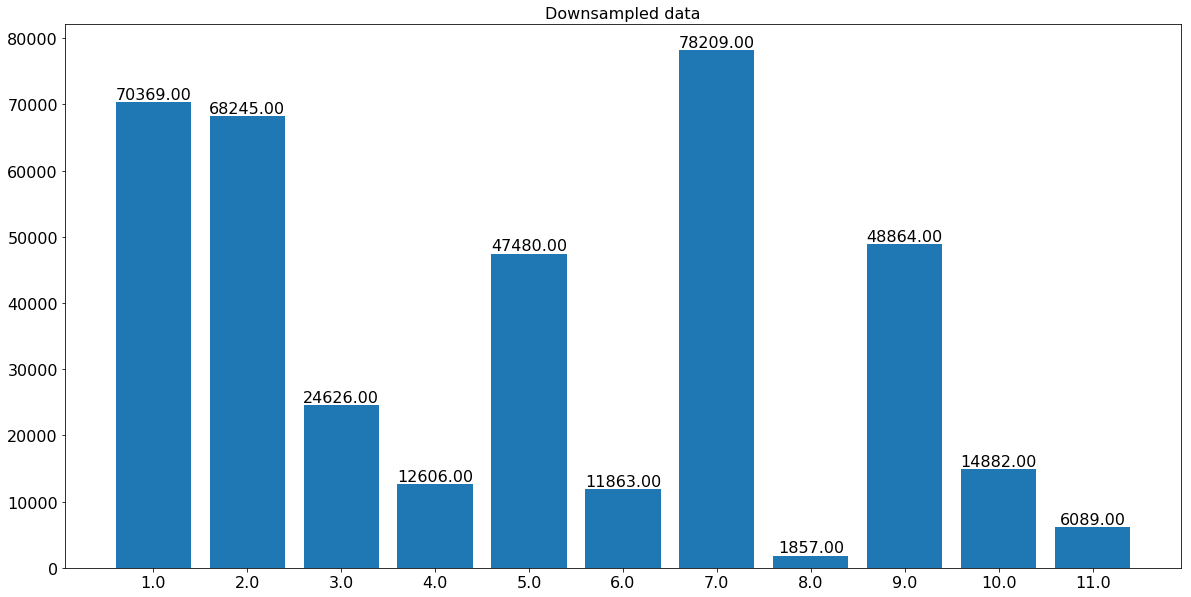

In [363]:
plot_count_mode(df_downsampled)

In [364]:
df_train = df_train.loc[df_train['sid'].isin(df_downsampled.sid.values)]


In [365]:
df_train.shape

(385090, 220)

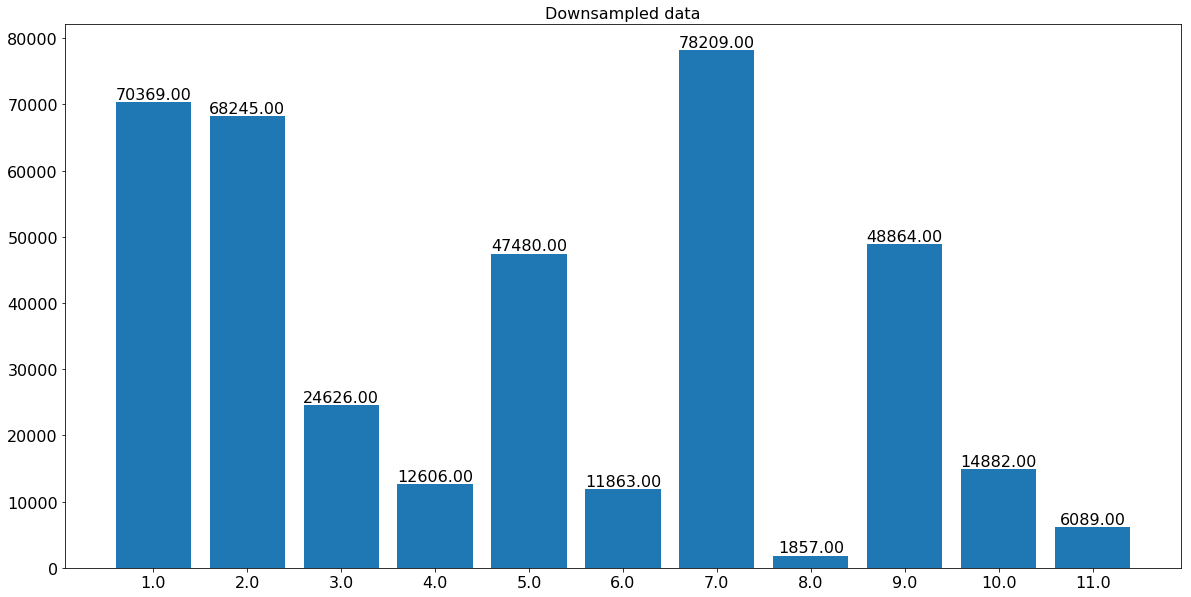

In [366]:
plot_count_mode(df_train)

In [367]:
df_train.click_mode = df_train.click_mode - 1

In [368]:
df_train.click_mode.unique()

array([ 8.,  0.,  6.,  4.,  2.,  1.,  9.,  5.,  3., 10.,  7.])

In [369]:
features_to_exclude = [
    'o1', 'o2', 'd1', 'd2', 'o_lat', 'o_long', 'd_lat', 'd_long',
    'pid', 'Response', 'sid', 'click_time', 'req_time', 'weather', 'plan_time',
    'req_date', 'Response_2'
]
df_train = df_train.drop(features_to_exclude, axis=1)
df_train = df_train.drop(df_train.loc[:,'p0':'p65'].head(0).columns, axis=1)

train_X = df_train.drop("click_mode", axis=1).values
train_y = df_train['click_mode'].values   

test_X = df_test.drop(['req_time', 'plan_time', 'req_date', 'weather'], axis=1).values

In [370]:
df_train.shape

(385090, 137)

In [371]:
df_preds = train_lgb_11(train_X, train_y, test_X)

Train LGB
Split Nr:  1
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.923831	valid_0's weighted-f1-score: 0.703321
[100]	valid_0's multi_logloss: 0.811962	valid_0's weighted-f1-score: 0.705224
[150]	valid_0's multi_logloss: 0.787482	valid_0's weighted-f1-score: 0.706653
[200]	valid_0's multi_logloss: 0.78057	valid_0's weighted-f1-score: 0.707034
[250]	valid_0's multi_logloss: 0.778396	valid_0's weighted-f1-score: 0.707547
[300]	valid_0's multi_logloss: 0.777659	valid_0's weighted-f1-score: 0.707891
[350]	valid_0's multi_logloss: 0.777535	valid_0's weighted-f1-score: 0.708058
Early stopping, best iteration is:
[349]	valid_0's multi_logloss: 0.777511	valid_0's weighted-f1-score: 0.708077
Split Nr:  1
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.922177	valid_0's weighted-f1-score: 0.702698
[100]	valid_0's multi_logloss: 0.809876	valid_0's weighted-f1-score: 0.704528
[150]	valid_0's multi_loglos

In [372]:
submit_result(submit, df_preds, 'lgb_down_0_trunc')

In [373]:
!ls

0.1_AV_understand_data.ipynb
0.1_FL_Create_Test_Train_Split.py
0.1_FL_Data_to_Multiclass_PreProcess.py
0.1_FL_add_features_to_multiclass_DFs.py
0.1_FL_multivariate_models_fitting.py
0.1_SVM_Multiclass_Approach.py
0.1_TF_Ranking_Basic_Intro.py
0.2_AV_LearningToRankExample.ipynb
0.2_FL_multivariate_models_fitting.py
0.4_AV_Preprocessing_Script.ipynb
0.5_AV_BaselineLightGBM.ipynb
1_AB_EDA.ipynb
1_LN_downsampling_functions.ipynb
2_AB_time_features.ipynb
2_LN_upsampling_functions.ipynb
3_AB_subways.ipynb
4_AB_weather.ipynb
5_AB_raw_preprocessing.ipynb
6_AB_check_raw_processed.ipynb
81_AV_tf_basline_multiclass.ipynb
lgb_down_0_trunc_result_2019-05-27-19-35-41.csv


In [376]:
df_train.head()

,mode_feas_0,mode_feas_1,mode_feas_2,mode_feas_3,mode_feas_4,mode_feas_5,mode_feas_6,mode_feas_7,mode_feas_8,mode_feas_9,...,svd_fea_16_2,svd_fea_17_2,svd_fea_18_2,svd_fea_19_2,dy,dyq,q,qdy,xq,xydy
0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.000000,0.000000,-0.000000,-0.000000,0,0,1,0,0,0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.091087,0.879959,0.022791,-0.246445,0,0,1,0,0,0
2,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.000000,0.000000,-0.000000,-0.000000,0,0,1,0,0,0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.052264,-0.082645,-0.121038,-0.334641,1,0,0,0,0,0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.035026,0.831827,0.082881,-0.049859,0,0,1,0,0,0


In [377]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [382]:
df_train[df_train.click_mode != 2].count()['sid']

363509

In [383]:
def down_half(df, mode):
    quantity = df[df.click_mode == mode].count()['sid']
    print('Quantity: ', quantity)
    half = quantity//2
    print('Half: ', half)
    df_without_mode = df[df.click_mode != mode]
    
    df_just_mode = df[df.click_mode == mode]
    df_just_mode = df_just_mode.sample(half)
    df_end = pd.concat([df_without_mode, df_just_mode])
    
    return df_end

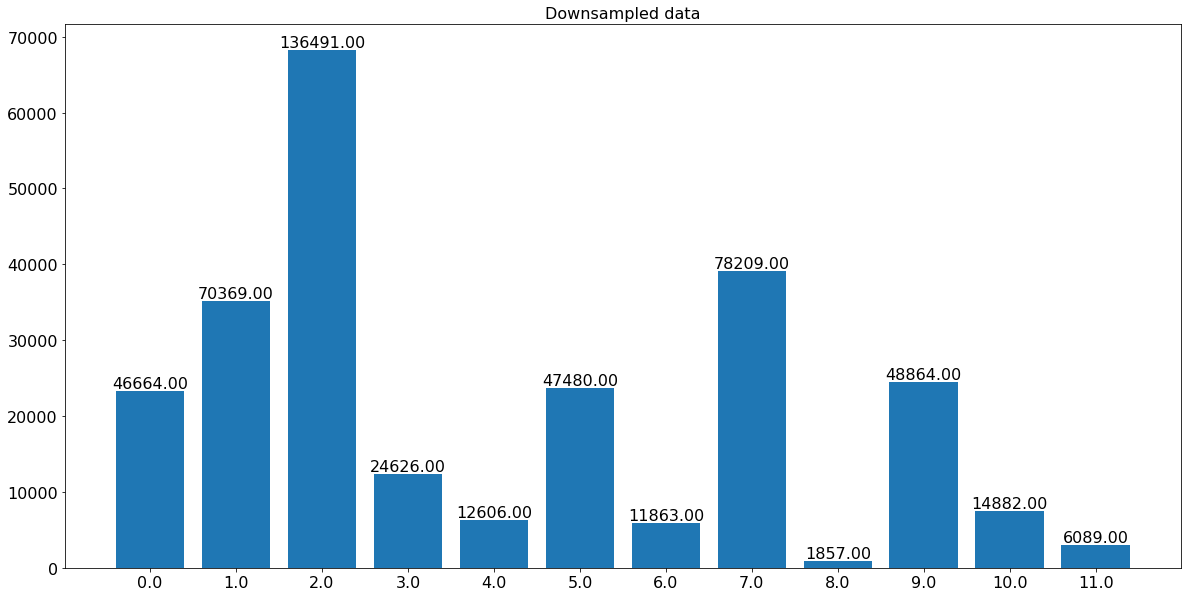

In [384]:
plot_count_mode(df_train)

In [385]:
df_end = down_half(df_train, 2)

Quantity:  136491
Half:  68245


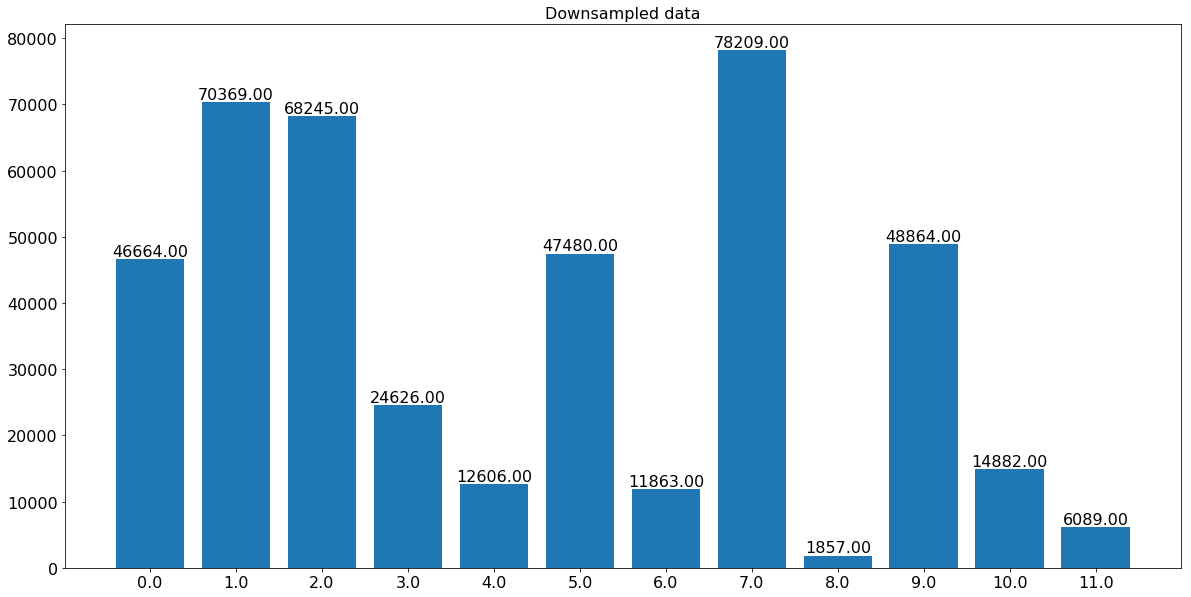

In [386]:
plot_count_mode(df_end)

## Train Down test not 

In [421]:
def train_lgb_downsampling(df_train_x, df_train_y, test_x):
    import numpy as np

    import lightgbm as lgb


    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score
    from time import gmtime, strftime

    import pandas as pd

    print('Train LGB')
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate': 0.05,
        'num_leaves': 60,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 12,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4
    }
    count = 1
    scores = []
    result_proba = []
    for tr_idx, val_idx in kfold.split(df_train_x, df_train_y):
        print('Split Nr: ', count)
        # Take one split
        tr_x, tr_y, val_x, val_y = df_train_x[tr_idx], fd_train_y[tr_idx], df_train_x[val_idx], df_train_y[val_idx]
        
        # Downsample tr_x
        df = pd.DataFrame([tr_x, tr_y])
        df_end = down_half(df, 2)
        
        
        train_set = lgb.Dataset(tr_x, tr_y)
        val_set = lgb.Dataset(val_x, val_y)
        # Train on this split
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=50,
                              num_boost_round=40000, verbose_eval=50, feval=eval_f_11)
        
        # Predict on best iteration of this split with validation set
        val_pred = np.argmax(lgb_model.predict(
            val_x, num_iteration=lgb_model.best_iteration), axis=1)
        
        # F1 val score
        val_score = f1_score(val_y, val_pred, average='weighted')
        
        # Predict with test set on best iteration of this split
        result_proba.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)
    
    lgb_model.predict
    
    return pred_test

In [428]:
import numpy as np

import lightgbm as lgb


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from time import gmtime, strftime

import pandas as pd

print('Train LGB')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
lgb_paras = {
    'objective': 'multiclass',
    'metrics': 'multiclass',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'num_class': 12,
    'seed': 2019,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4
}
count = 1
scores = []
result_proba = []
for tr_idx, val_idx in kfold.split(train_X, train_y):
    print('Split Nr: ', count)
    print(tr_idx)
    df_end = down_half(df_train[tr_idx], 2)
    print(tr_idx)
    
    # Take one split
    tr_x, tr_y, val_x, val_y = df_train_x[tr_idx], fd_train_y[tr_idx], df_train_x[val_idx], df_train_y[val_idx]

    # Downsample tr_x
    

    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    # Train on this split
    lgb_model = lgb.train(lgb_paras, train_set,
                          valid_sets=[val_set], early_stopping_rounds=50,
                          num_boost_round=40000, verbose_eval=50, feval=eval_f_11)

    # Predict on best iteration of this split with validation set
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)

    # F1 val score
    val_score = f1_score(val_y, val_pred, average='weighted')

    # Predict with test set on best iteration of this split
    result_proba.append(lgb_model.predict(
        test_x, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
print('cv f1-score: ', np.mean(scores))

Train LGB
Split Nr:  1
[     2      3      5 ... 499995 499998 499999]


KeyError: "None of [Int64Index([     2,      3,      5,      6,      7,      8,      9,     11,\n                12,     13,\n            ...\n            499985, 499986, 499987, 499988, 499989, 499990, 499992, 499995,\n            499998, 499999],\n           dtype='int64', length=399995)] are in the [columns]"

In [422]:
df_preds = train_lgb_downsampling(train_X, train_y, test_X)

Train LGB
Split Nr:  1


KeyError: "None of [Int64Index([     2,      3,      5,      6,      7,      8,      9,     11,\n                12,     13,\n            ...\n            499985, 499986, 499987, 499988, 499989, 499990, 499992, 499995,\n            499998, 499999],\n           dtype='int64', length=399995)] are in the [columns]"

In [529]:
features = [
    'o1',
    'o2',
    'd1',
    'd2',
    'mode_feas_0',
    'mode_feas_1',
    'mode_feas_2',
    'mode_feas_3',
    'mode_feas_4',
    'mode_feas_5',
    'mode_feas_6',
    'mode_feas_7',
    'mode_feas_8',
    'mode_feas_9',
    'mode_feas_10',
    'mode_feas_11',
    'max_dist',
    'min_dist',
    'mean_dist',
    'std_dist',
    'max_price',
    'min_price',
    'mean_price',
    'std_price',
    'max_eta',
    'min_eta',
    'mean_eta',
    'std_eta',
    'max_dist_mode',
    'min_dist_mode',
    'max_price_mode',
    'min_price_mode',
    'max_eta_mode',
    'min_eta_mode',
    'first_mode',
    'weekday',
    'hour',
    'distance_query',
    'dist_nearest_sub',
    'dyq',
    'qdy',
    'dy',
    'q',
    'xydy',
    'xq',
    'max_temp',
    'min_temp',
    'wind',
    'req_weekend',
    'is_holiday',
    'p0',
    'p1',
    'p2',
    'p3',
    'p4',
    'p5',
    'p6',
    'p7',
    'p8',
    'p9',
    'p10',
    'p11',
    'p12',
    'p13',
    'p14',
    'p15',
    'p16',
    'p17',
    'p18',
    'p19',
    'p20',
    'p21',
    'p22',
    'p23',
    'p24',
    'p25',
    'p26',
    'p27',
    'p28',
    'p29',
    'p30',
    'p31',
    'p32',
    'p33',
    'p34',
    'p35',
    'p36',
    'p37',
    'p38',
    'p39',
    'p40',
    'p41',
    'p42',
    'p43',
    'p44',
    'p45',
    'p46',
    'p47',
    'p48',
    'p49',
    'p50',
    'p51',
    'p52',
    'p53',
    'p54',
    'p55',
    'p56',
    'p57',
    'p58',
    'p59',
    'p60',
    'p61',
    'p62',
    'p63',
    'p64',
    'p65'
]

In [531]:
import pickle

with open('../data/interim/features_pid_all.pickle', 'wb') as fp:
    pickle.dump(features, fp)

In [532]:
with open ('../data/interim/features_pid_all.pickle', 'rb') as fp:
    itemlist = pickle.load(fp)

In [418]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

features_to_exclude = [
    'o1', 'o2', 'd1', 'd2', 'o_lat', 'o_long', 'd_lat', 'd_long',
    'pid', 'Response', 'sid', 'click_time', 'req_time', 'weather', 'plan_time',
    'req_date', 'Response_2'
]
# df_train = df_train.drop(features_to_exclude, axis=1)
# df_train = df_train.drop(df_train.loc[:,'p0':'p65'].head(0).columns, axis=1)
df_train = df_train[features + ['click_mode']]

df_test = pd.read_pickle("../data/interim/Test_extern_git_feat.pickle")
df_test = df_test[features]


train_X = df_train.drop("click_mode", axis=1)
train_y = df_train['click_mode']   


In [473]:
test_x = df_test[features].values

In [468]:
test_X.shape

(94358, 116)

In [469]:
len(features)

116

In [411]:
train_X.shape

(500000, 116)

In [412]:
train_y.shape

(500000,)

In [413]:
test_X.shape

(94358, 116)

In [435]:
split_1 = pd.read_pickle('../data/interim/splits/SIDs_1.txt')
split_2 = pd.read_pickle('../data/interim/splits/SIDs_2.txt')
split_3 = pd.read_pickle('../data/interim/splits/SIDs_3.txt')
split_4 = pd.read_pickle('../data/interim/splits/SIDs_4.txt')
split_5 = pd.read_pickle('../data/interim/splits/SIDs_5.txt')
SIDs = [split_1, split_2, split_3, split_4, split_5]

In [516]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")


In [517]:
modes = df_train.click_mode.unique()
modes.sort()
modes

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [519]:
import lightgbm as lgb

df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")
print("df train shape", df_train.shape)

data = df_train.copy()

lgb_paras = {
    'objective': 'multiclass',
    'metrics': 'multiclass',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'num_class': 12,
    'seed': 2019,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4
}
count = 1
scores = []
result_proba = []

# Loop over the different Test/Train Splits
for i in range(len(SIDs)):

    # Print process
    print(str(i) + " / " + str(len(SIDs) - 1))

    # Extract the Test_Set based on the current SID:
    val_x          = data.loc[data["sid"].isin(SIDs[i]), features].values
    val_y = data.loc[data["sid"].isin(SIDs[i]), "click_mode"].values

    # Extract the SIDs we use for training, and select correponding train points!
    train_sids = []
    for j in range(len(SIDs)):
        if j != i:
            train_sids = train_sids + SIDs[j]

    df_train_split = data.loc[data["sid"].isin(train_sids), :]
    df_downsampled = down_half(df_train_split, 2)
    
    
    tr_x = df_downsampled[features].values
    tr_y = df_downsampled['click_mode'].values
    
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    # Train on this split
    lgb_model = lgb.train(lgb_paras, train_set,
                          valid_sets=[val_set], early_stopping_rounds=50,
                          num_boost_round=40000, verbose_eval=50, feval=eval_f)

    # Predict on best iteration of this split with validation set
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)

    # F1 val score
    val_score = f1_score(val_y, val_pred, average='weighted')

    # Predict with test set on best iteration of this split
    result_proba.append(lgb_model.predict(
        test_x, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
print('cv f1-score: ', np.mean(scores))
pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)

df train shape (500000, 220)
0 / 4
Quantity:  109165
Half:  54582
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.05433	valid_0's weighted-f1-score: 0.672311
[100]	valid_0's multi_logloss: 0.937456	valid_0's weighted-f1-score: 0.675015
[150]	valid_0's multi_logloss: 0.910523	valid_0's weighted-f1-score: 0.676657
[200]	valid_0's multi_logloss: 0.902261	valid_0's weighted-f1-score: 0.677794
[250]	valid_0's multi_logloss: 0.899411	valid_0's weighted-f1-score: 0.678608
[300]	valid_0's multi_logloss: 0.898019	valid_0's weighted-f1-score: 0.678961
[350]	valid_0's multi_logloss: 0.897457	valid_0's weighted-f1-score: 0.679146
Early stopping, best iteration is:
[337]	valid_0's multi_logloss: 0.89756	valid_0's weighted-f1-score: 0.679374
1 / 4
Quantity:  109294
Half:  54647
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.04883	valid_0's weighted-f1-score: 0.676033
[100]	valid_0's multi_logloss: 0.930763	v

In [481]:
print('cv f1-score: ', np.mean(scores))

pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)

cv f1-score:  0.7368928788599519


In [482]:
submit_result(submit, pred_test, 'lgb_down')

In [494]:
lgb = pd.read_csv("lgb_down_result_2019-05-28-09-03-45.csv")
lgb.head()

,sid,recommend_mode
0,1126541,2
1,453685,1
2,2066073,7
3,452746,2
4,1431672,5


In [495]:
rf = pd.read_csv("../data/interim/RF_100_all_features.csv", header=None)
rf.columns=["sid", "recommend_mode"]
rf.head()

,sid,recommend_mode
0,1126541,2.0
1,453685,1.0
2,2066073,7.0
3,452746,2.0
4,1431672,5.0


In [497]:
rf[rf.recommend_mode == 0].count()

sid               2306
recommend_mode    2306
dtype: int64

In [499]:
sid_zero = rf.loc[rf.recommend_mode == 0, 'sid']

In [509]:
rf.loc[rf.recommend_mode == 0, 'recommend_mode'] = lgb.loc[lgb.sid.isin(sid_zero), 'recommend_mode']

In [510]:
rf.groupby("recommend_mode").count()

,sid
recommend_mode,
1.0,17862
2.0,34398
3.0,2109
4.0,117
5.0,10957
6.0,307
7.0,22630
8.0,248
9.0,2090


In [520]:
# With adjusted hyperparameter
import lightgbm as lgb

df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")
print("df train shape", df_train.shape)

data = df_train.copy()

lgb_paras = {
    'objective': 'multiclass',
    'metrics': 'multiclass',
    'learning_rate': 0.05,
    'num_leaves': 25,
    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'num_class': 12,
    'seed': 2019,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4,
    'colsample_bytree': 0.9492410177317588,
    'min_child_samples': 243,
    'min_child_weight': 1,
    'reg_alpha': 10,
    'reg_lambda': 0.1, 
    'subsample': 0.4592512443442188
}
count = 1
scores = []
result_proba = []

# Loop over the different Test/Train Splits
for i in range(len(SIDs)):

    # Print process
    print(str(i) + " / " + str(len(SIDs) - 1))

    # Extract the Test_Set based on the current SID:
    val_x          = data.loc[data["sid"].isin(SIDs[i]), features].values
    val_y = data.loc[data["sid"].isin(SIDs[i]), "click_mode"].values

    # Extract the SIDs we use for training, and select correponding train points!
    train_sids = []
    for j in range(len(SIDs)):
        if j != i:
            train_sids = train_sids + SIDs[j]

    df_train_split = data.loc[data["sid"].isin(train_sids), :]
    df_downsampled = down_half(df_train_split, 2)
    
    
    tr_x = df_downsampled[features].values
    tr_y = df_downsampled['click_mode'].values
    
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    # Train on this split
    lgb_model = lgb.train(lgb_paras, train_set,
                          valid_sets=[val_set], early_stopping_rounds=50,
                          num_boost_round=40000, verbose_eval=50, feval=eval_f)

    # Predict on best iteration of this split with validation set
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)

    # F1 val score
    val_score = f1_score(val_y, val_pred, average='weighted')

    # Predict with test set on best iteration of this split
    result_proba.append(lgb_model.predict(
        test_x, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
print('cv f1-score: ', np.mean(scores))
pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)

df train shape (500000, 220)
0 / 4
Quantity:  109165
Half:  54582
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.06085	valid_0's weighted-f1-score: 0.669223
[100]	valid_0's multi_logloss: 0.942683	valid_0's weighted-f1-score: 0.672957
[150]	valid_0's multi_logloss: 0.914746	valid_0's weighted-f1-score: 0.675205
[200]	valid_0's multi_logloss: 0.905681	valid_0's weighted-f1-score: 0.676459
[250]	valid_0's multi_logloss: 0.902385	valid_0's weighted-f1-score: 0.6772
[300]	valid_0's multi_logloss: 0.900598	valid_0's weighted-f1-score: 0.677726
[350]	valid_0's multi_logloss: 0.89967	valid_0's weighted-f1-score: 0.67794
[400]	valid_0's multi_logloss: 0.899211	valid_0's weighted-f1-score: 0.67807
[450]	valid_0's multi_logloss: 0.898812	valid_0's weighted-f1-score: 0.67835
Early stopping, best iteration is:
[426]	valid_0's multi_logloss: 0.898999	valid_0's weighted-f1-score: 0.678504
1 / 4
Quantity:  109294
Half:  54647
Training until validation sc

/home/sandro/anaconda3/envs/lbm_mc_bl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[50]	valid_0's multi_logloss: 1.05418	valid_0's weighted-f1-score: 0.675223
[100]	valid_0's multi_logloss: 0.93589	valid_0's weighted-f1-score: 0.677983
[150]	valid_0's multi_logloss: 0.908262	valid_0's weighted-f1-score: 0.679618
[200]	valid_0's multi_logloss: 0.899537	valid_0's weighted-f1-score: 0.680671
[250]	valid_0's multi_logloss: 0.896278	valid_0's weighted-f1-score: 0.68131
[300]	valid_0's multi_logloss: 0.894769	valid_0's weighted-f1-score: 0.682186
[350]	valid_0's multi_logloss: 0.894046	valid_0's weighted-f1-score: 0.68235
[400]	valid_0's multi_logloss: 0.893606	valid_0's weighted-f1-score: 0.68226
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.894046	valid_0's weighted-f1-score: 0.68235
3 / 4
Quantity:  108970
Half:  54485
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.05527	valid_0's weighted-f1-score: 0.673547
[100]	valid_0's multi_logloss: 0.935933	valid_0's weighted-f1-score: 0.677625
[150]	valid_0's m

## With truncated pids

In [534]:
features = [
    'o1',
    'o2',
    'd1',
    'd2',
    'mode_feas_0',
    'mode_feas_1',
    'mode_feas_2',
    'mode_feas_3',
    'mode_feas_4',
    'mode_feas_5',
    'mode_feas_6',
    'mode_feas_7',
    'mode_feas_8',
    'mode_feas_9',
    'mode_feas_10',
    'mode_feas_11',
    'max_dist',
    'min_dist',
    'mean_dist',
    'std_dist',
    'max_price',
    'min_price',
    'mean_price',
    'std_price',
    'max_eta',
    'min_eta',
    'mean_eta',
    'std_eta',
    'max_dist_mode',
    'min_dist_mode',
    'max_price_mode',
    'min_price_mode',
    'max_eta_mode',
    'min_eta_mode',
    'first_mode',
    'weekday',
    'hour',
    'distance_query',
    'dist_nearest_sub',
    'dyq',
    'qdy',
    'dy',
    'q',
    'xydy',
    'xq',
    'max_temp',
    'min_temp',
    'wind',
    'req_weekend',
    'is_holiday',
    'svd_fea_0',
    'svd_fea_1',
    'svd_fea_2',
    'svd_fea_3',
    'svd_fea_4',
    'svd_fea_5',
    'svd_fea_6',
    'svd_fea_7',
    'svd_fea_8',
    'svd_fea_9',
    'svd_fea_10',
    'svd_fea_11',
    'svd_fea_12',
    'svd_fea_13',
    'svd_fea_14',
    'svd_fea_15',
    'svd_fea_16',
    'svd_fea_17',
    'svd_fea_18',
    'svd_fea_19'
]

In [538]:
# With adjusted hyperparameter
import lightgbm as lgb

df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")
print("df train shape", df_train.shape)

data = df_train.copy()


lgb_paras = {
    'objective': 'multiclass',
    'metrics': 'multiclass',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'num_class': 12,
    'seed': 2019,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4
}
count = 1
scores = []
result_proba = []

# Loop over the different Test/Train Splits
for i in range(len(SIDs)):

    # Print process
    print(str(i) + " / " + str(len(SIDs) - 1))

    # Extract the Test_Set based on the current SID:
    val_x          = data.loc[data["sid"].isin(SIDs[i]), features].values
    val_y = data.loc[data["sid"].isin(SIDs[i]), "click_mode"].values

    # Extract the SIDs we use for training, and select correponding train points!
    train_sids = []
    for j in range(len(SIDs)):
        if j != i:
            train_sids = train_sids + SIDs[j]

    df_train_split = data.loc[data["sid"].isin(train_sids), :]
    df_downsampled = down_half(df_train_split, 2)
    
    
    tr_x = df_downsampled[features].values
    tr_y = df_downsampled['click_mode'].values
    
    print("Train shape:", tr_x.shape)
    
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    # Train on this split
    lgb_model = lgb.train(lgb_paras, train_set,
                          valid_sets=[val_set], early_stopping_rounds=50,
                          num_boost_round=40000, verbose_eval=50, feval=eval_f)

    # Predict on best iteration of this split with validation set
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)

    # F1 val score
    val_score = f1_score(val_y, val_pred, average='weighted')

    # Predict with test set on best iteration of this split
    result_proba.append(lgb_model.predict(
        test_x, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
print('cv f1-score: ', np.mean(scores))
pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)

df train shape (500000, 220)
0 / 4
Quantity:  109165
Half:  54582
Train shape: (345417, 70)
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.05631	valid_0's weighted-f1-score: 0.671834
[100]	valid_0's multi_logloss: 0.938001	valid_0's weighted-f1-score: 0.674702
[150]	valid_0's multi_logloss: 0.911006	valid_0's weighted-f1-score: 0.67653
[200]	valid_0's multi_logloss: 0.90266	valid_0's weighted-f1-score: 0.677889
[250]	valid_0's multi_logloss: 0.899489	valid_0's weighted-f1-score: 0.678183
[300]	valid_0's multi_logloss: 0.897906	valid_0's weighted-f1-score: 0.678521
[350]	valid_0's multi_logloss: 0.897096	valid_0's weighted-f1-score: 0.678986
[400]	valid_0's multi_logloss: 0.896692	valid_0's weighted-f1-score: 0.678969
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 0.896826	valid_0's weighted-f1-score: 0.67909
1 / 4
Quantity:  109294
Half:  54647
Train shape: (345353, 70)
Training until validation scores don't improve for 

## Training with pid=-1 / with 0 / without padding

In [543]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat_pid_-1.pickle")

In [546]:
df_train.shape

(500000, 200)

In [547]:
df_train.head()

,o1,o2,d1,d2,mode_feas_0,mode_feas_1,mode_feas_2,mode_feas_3,mode_feas_4,mode_feas_5,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,116.29,39.97,116.32,39.96,0.0,0.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,116.31,39.93,116.27,40.00,0.0,0.0,1.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,116.43,39.95,116.37,39.86,0.0,1.0,0.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,116.32,39.98,116.58,39.91,0.0,1.0,1.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,116.31,40.03,116.33,40.01,0.0,1.0,0.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [551]:
df_train[df_train.pid == 196549.0]



,o1,o2,d1,d2,mode_feas_0,mode_feas_1,mode_feas_2,mode_feas_3,mode_feas_4,mode_feas_5,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
499970,116.33,39.89,116.34,39.89,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [542]:
import src.models.lgbm_multiclass_baseline.lgbm_mc_bl

ModuleNotFoundError: No module named 'src'

In [552]:
df_test = pd.read_pickle("../data/interim/Test_extern_git_feat.pickle")

In [553]:
df_test.head()

,o1,o2,d1,d2,mode_feas_0,mode_feas_1,mode_feas_2,mode_feas_3,mode_feas_4,mode_feas_5,...,svd_fea_16_2,svd_fea_17_2,svd_fea_18_2,svd_fea_19_2,dy,dyq,q,qdy,xq,xydy
0,116.41,39.92,116.46,39.95,0.0,0.0,1.0,1.0,1.0,0.0,...,-0.077330,-0.000219,-0.028203,0.001029,1,0,0,0,0,0
1,116.39,39.90,116.41,39.91,0.0,1.0,0.0,1.0,1.0,1.0,...,-0.276405,-0.052869,0.083237,0.354277,1,0,0,0,0,0
2,116.37,39.71,116.31,39.89,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.058804,-0.011177,-0.043082,-0.247059,0,0,1,0,0,0
3,116.33,39.97,116.31,39.98,0.0,1.0,1.0,1.0,1.0,1.0,...,-0.169231,0.042898,0.088479,0.155605,1,0,0,0,0,0
4,116.51,39.68,116.51,39.68,0.0,1.0,0.0,1.0,0.0,1.0,...,0.037629,-0.314890,0.821286,0.026792,0,0,1,0,0,0


In [595]:
df_test.to_pickle("../data/interim/Test_extern_git_feat_pid_-1.pickle")

In [559]:
profiles = pd.read_csv("../data/raw/data_set_phase1/profiles.csv")

In [562]:
profile_na = np.zeros(67)
profile_na[0] = -1

In [567]:
profile_na = np.zeros(67)
profile_na[0] = -1
profile_na = pd.DataFrame(profile_na.reshape(1, -1))
profile_na.columns = profiles.columns

In [569]:
profile_na.iloc[0] = -1

In [570]:
profile_na

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [560]:

profile_data = pd.read_csv('../data/profiles.csv')
profile_na = np.zeros(67)
profile_na[0] = -1
profile_na = pd.DataFrame(profile_na.reshape(1, -1))
profile_na.columns = profile_data.columns
profile_data = profile_data.append(profile_na)


,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,115511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,129719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,174347,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,143618,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,116999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,194535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,125275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Sample 2 down and 8 on 3 and 11 on 3

In [743]:
df_train = pd.read_pickle("../data/interim/Train_extern_git_feat_pid_-1.pickle")

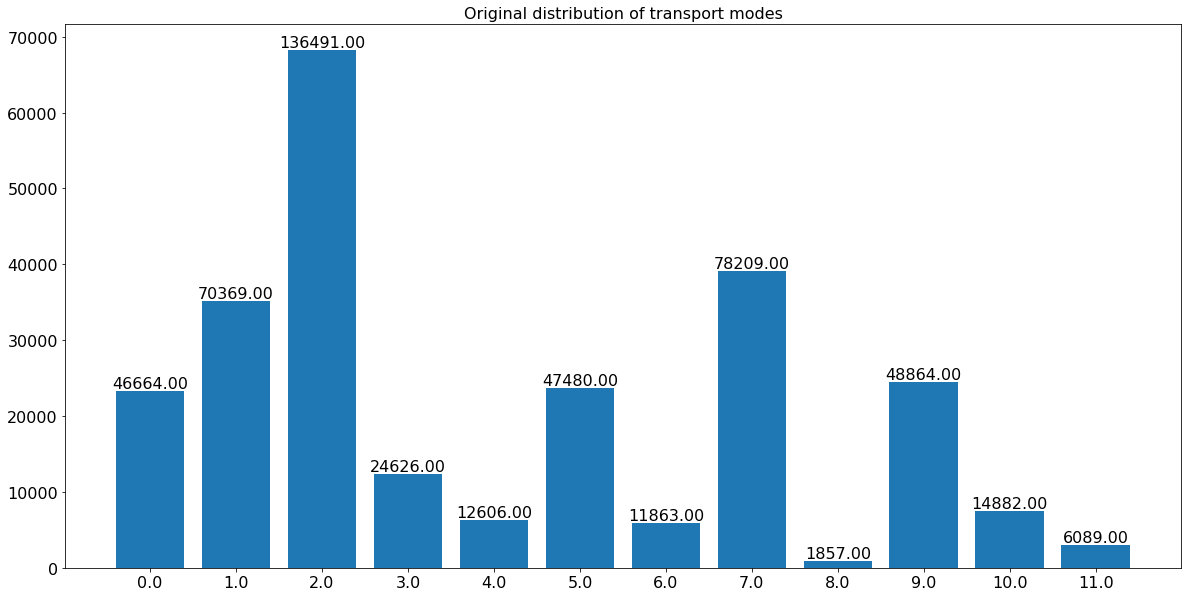

In [744]:
fig = plot_count_mode(df_train, 'Original distribution of transport modes')

In [745]:
fig.savefig("../data/interim/orig_data_sampling.png", bbox_inches='tight')

In [733]:
df_sampled = down_half(df_train, 2)

Quantity:  136491
Half:  68245


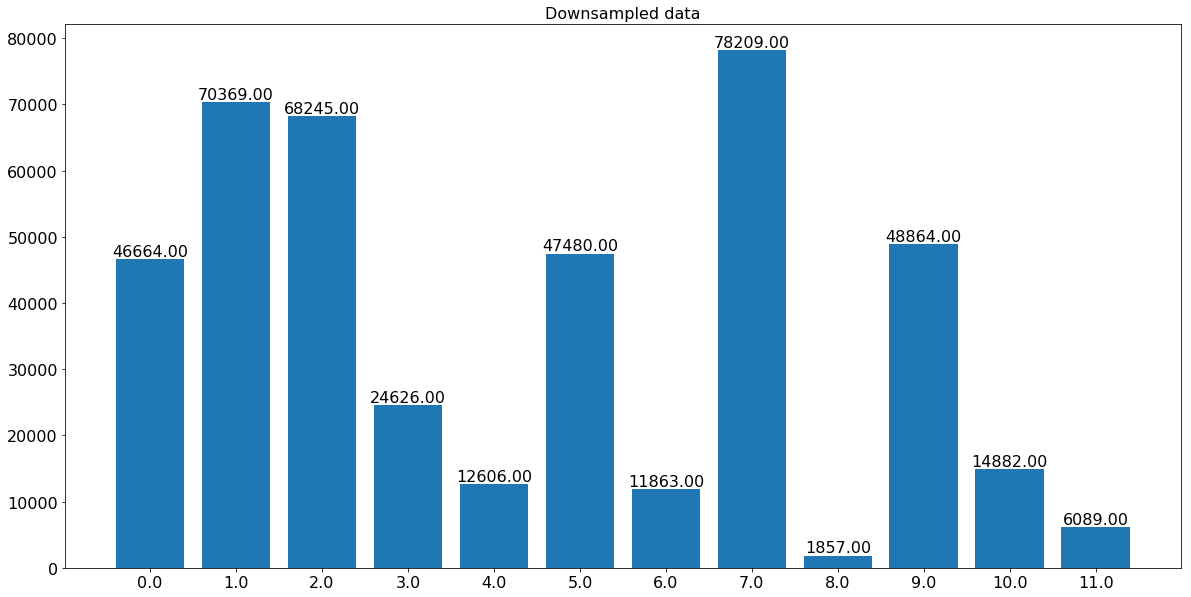

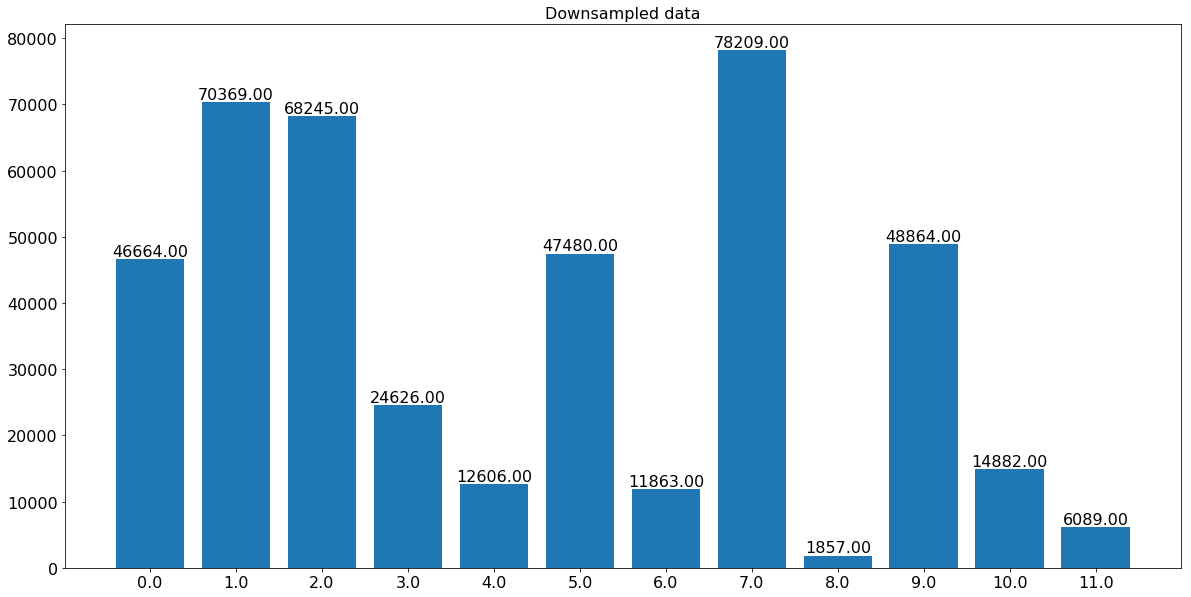

In [734]:
plot_count_mode(df_sampled)

In [606]:
df_train.groupby('click_mode').count().loc[3, 'sid']

24626

In [616]:
print(df_train.groupby('click_mode').count()['sid'])

click_mode
0.0      46664
1.0      70369
2.0     136491
3.0      24626
4.0      12606
5.0      47480
6.0      11863
7.0      78209
8.0       1857
9.0      48864
10.0     14882
11.0      6089
Name: sid, dtype: int64


In [608]:
def up_othermode(df, mode, target_mode):
    new_quantity = df.groupby('click_mode').count().loc[target_mode, 'sid']
    df_just_mode =df.loc[df.click_mode == mode]
    
    df_mode_target = df_just_mode.sample(new_quantity, replace=True)
    df = df.loc[df.click_mode != mode]
    df = pd.concat([df_mode_target, df], axis=0)
    return df

In [609]:
df_sampled = up_othermode(df_sampled, 8, 3)

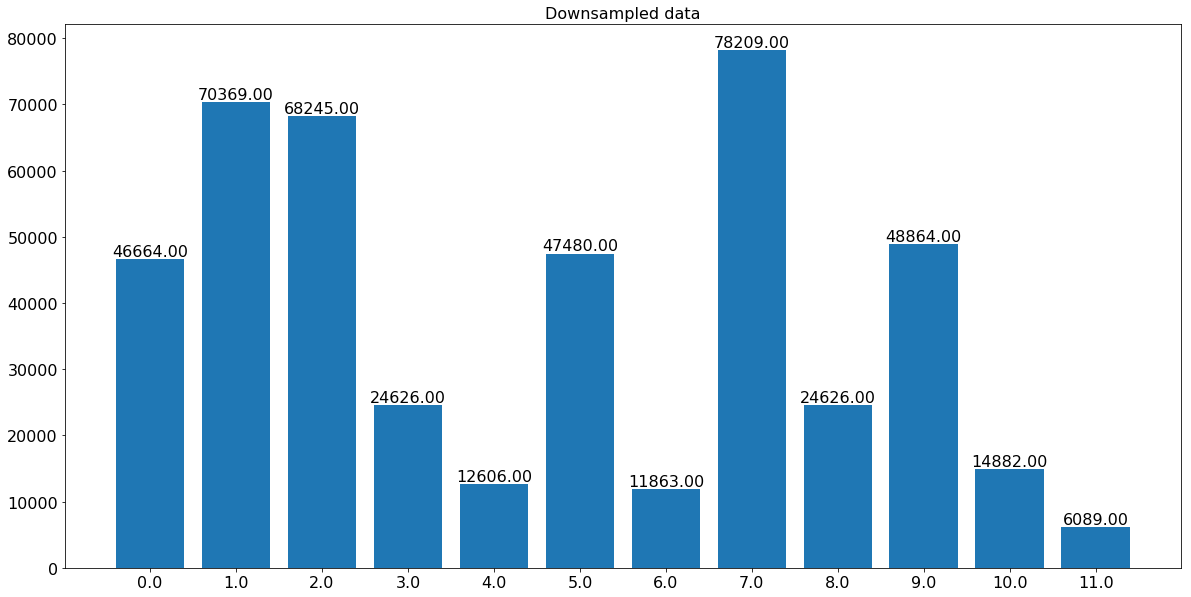

In [610]:
plot_count_mode(df_sampled)

In [622]:
def downsample(df, mode, amount):
    df_just_mode =df.loc[df.click_mode == mode]  
    df_mode_target = df_just_mode.sample(amount, replace=True)
    df = df.loc[df.click_mode != mode]
    df = pd.concat([df_mode_target, df], axis=0)

    return df

In [623]:
def upsample(df, mode, amount):
    df_just_mode =df.loc[df.click_mode == mode]  

    df_mode_target = df_just_mode.sample(amount, replace=True)
    df = df.loc[df.click_mode != mode]
    df = pd.concat([df_mode_target, df], axis=0)
    return df

In [746]:
df_sampled = df_train.copy()

In [747]:
df_sampled = downsample(df_sampled, 2, 70000)

In [748]:
df_sampled = upsample(df_sampled, 4, 20000)
df_sampled = upsample(df_sampled, 5, 20000)
df_sampled = upsample(df_sampled, 8, 3000)
df_sampled = upsample(df_sampled, 10, 20000)


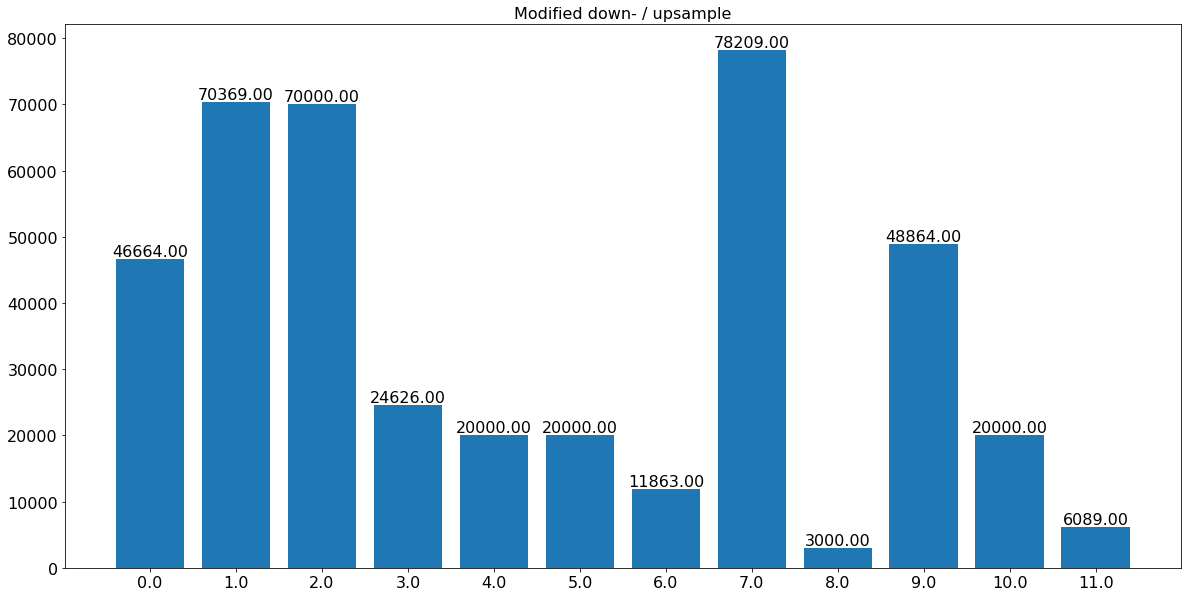

In [749]:
fig = plot_count_mode(df_sampled, 'Modified down- / upsample')

In [750]:
fig.savefig("../data/interim/sampled.png", bbox_inches='tight')

In [628]:
df_train_old = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")

In [631]:
list(df_train_old.columns)

['o1',
 'o2',
 'd1',
 'd2',
 'mode_feas_0',
 'mode_feas_1',
 'mode_feas_2',
 'mode_feas_3',
 'mode_feas_4',
 'mode_feas_5',
 'mode_feas_6',
 'mode_feas_7',
 'mode_feas_8',
 'mode_feas_9',
 'mode_feas_10',
 'mode_feas_11',
 'max_dist',
 'min_dist',
 'mean_dist',
 'std_dist',
 'max_price',
 'min_price',
 'mean_price',
 'std_price',
 'max_eta',
 'min_eta',
 'mean_eta',
 'std_eta',
 'max_dist_mode',
 'min_dist_mode',
 'max_price_mode',
 'min_price_mode',
 'max_eta_mode',
 'min_eta_mode',
 'first_mode',
 'svd_mode_0',
 'svd_mode_1',
 'svd_mode_2',
 'svd_mode_3',
 'svd_mode_4',
 'svd_mode_5',
 'svd_mode_6',
 'svd_mode_7',
 'svd_mode_8',
 'svd_mode_9',
 'svd_fea_0',
 'svd_fea_1',
 'svd_fea_2',
 'svd_fea_3',
 'svd_fea_4',
 'svd_fea_5',
 'svd_fea_6',
 'svd_fea_7',
 'svd_fea_8',
 'svd_fea_9',
 'svd_fea_10',
 'svd_fea_11',
 'svd_fea_12',
 'svd_fea_13',
 'svd_fea_14',
 'svd_fea_15',
 'svd_fea_16',
 'svd_fea_17',
 'svd_fea_18',
 'svd_fea_19',
 'weekday',
 'hour',
 'Response',
 'sid',
 'click_time',

In [632]:
features

['o1',
 'o2',
 'd1',
 'd2',
 'mode_feas_0',
 'mode_feas_1',
 'mode_feas_2',
 'mode_feas_3',
 'mode_feas_4',
 'mode_feas_5',
 'mode_feas_6',
 'mode_feas_7',
 'mode_feas_8',
 'mode_feas_9',
 'mode_feas_10',
 'mode_feas_11',
 'max_dist',
 'min_dist',
 'mean_dist',
 'std_dist',
 'max_price',
 'min_price',
 'mean_price',
 'std_price',
 'max_eta',
 'min_eta',
 'mean_eta',
 'std_eta',
 'max_dist_mode',
 'min_dist_mode',
 'max_price_mode',
 'min_price_mode',
 'max_eta_mode',
 'min_eta_mode',
 'first_mode',
 'weekday',
 'hour',
 'distance_query',
 'dist_nearest_sub',
 'dyq',
 'qdy',
 'dy',
 'q',
 'xydy',
 'xq',
 'max_temp',
 'min_temp',
 'wind',
 'req_weekend',
 'is_holiday',
 'svd_fea_0',
 'svd_fea_1',
 'svd_fea_2',
 'svd_fea_3',
 'svd_fea_4',
 'svd_fea_5',
 'svd_fea_6',
 'svd_fea_7',
 'svd_fea_8',
 'svd_fea_9',
 'svd_fea_10',
 'svd_fea_11',
 'svd_fea_12',
 'svd_fea_13',
 'svd_fea_14',
 'svd_fea_15',
 'svd_fea_16',
 'svd_fea_17',
 'svd_fea_18',
 'svd_fea_19']

In [641]:
import sys
sys.path.append("../src/")
from models.utils import load_model
model = load_model('../models/split_2_27')
model.predict(test_X.values)

Load model...
Model was loaded!


array([[5.22095796e-02, 8.42730239e-05, 7.84435494e-01, ...,
        6.41251464e-02, 7.50691352e-05, 3.62295522e-05],
       [8.23235228e-02, 7.43040788e-01, 1.20695664e-04, ...,
        6.96678129e-05, 4.57984021e-05, 4.72808007e-05],
       [5.42087290e-02, 4.76634443e-02, 7.39383396e-05, ...,
        1.07990930e-04, 1.05030694e-01, 7.31489406e-05],
       ...,
       [5.00607877e-02, 1.88754924e-04, 1.06240604e-04, ...,
        1.25385262e-04, 4.52848358e-05, 8.33727320e-05],
       [1.11953336e-01, 1.69011373e-04, 1.71773631e-04, ...,
        5.69150971e-01, 2.64167742e-04, 6.15738719e-05],
       [7.09569216e-02, 9.03166634e-02, 9.19492042e-05, ...,
        7.74610454e-05, 1.14591392e-04, 8.86945163e-02]])

## With new dataset from ANE

In [643]:
df_train_all_first = pd.read_pickle("../data/interim/processed_all/train_all_first.pickle")

In [665]:
df_test_all_first = pd.read_pickle("../data/interim/processed_all/test_all_first.pickle")

In [650]:
df_train_all_first.shape

(500000, 125)

In [645]:
df_train_all_first.head()

,sid,click_time,click_mode,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query,...,req_hour,req_weekend,req_night,req_day,req_evening,is_holiday,max_temp,min_temp,weather,wind
0,2848914.0,2018-11-17 18:42:17,1.0,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,0.456070,...,12,1,0,1,0,0,9,-2,dyq,12
1,2848913.0,2018-11-17 22:25:29,2.0,101804.0,2018-11-17 22:25:16,116.41,39.92,116.39,39.99,0.072801,...,22,1,0,0,1,0,9,-2,dyq,12
2,2542469.0,2018-11-19 10:30:57,2.0,101804.0,2018-11-19 10:30:50,116.61,40.05,116.41,39.92,0.238537,...,10,0,0,1,0,0,10,-2,qdy,12
3,381188.0,2018-10-05 12:37:07,2.0,101804.0,2018-10-05 12:37:05,116.42,39.88,116.58,40.08,0.256125,...,12,1,0,1,0,1,24,14,dy,12
4,1601376.0,2018-10-03 13:32:30,1.0,101804.0,2018-10-03 13:27:35,116.37,39.95,116.39,39.89,0.063246,...,13,0,0,1,0,1,25,10,q,12


In [656]:
list(df_train_all_first.columns)

['sid',
 'click_time',
 'click_mode',
 'pid',
 'req_time',
 'o_long',
 'o_lat',
 'd_long',
 'd_lat',
 'distance_query',
 'p0',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16',
 'p17',
 'p18',
 'p19',
 'p20',
 'p21',
 'p22',
 'p23',
 'p24',
 'p25',
 'p26',
 'p27',
 'p28',
 'p29',
 'p30',
 'p31',
 'p32',
 'p33',
 'p34',
 'p35',
 'p36',
 'p37',
 'p38',
 'p39',
 'p40',
 'p41',
 'p42',
 'p43',
 'p44',
 'p45',
 'p46',
 'p47',
 'p48',
 'p49',
 'p50',
 'p51',
 'p52',
 'p53',
 'p54',
 'p55',
 'p56',
 'p57',
 'p58',
 'p59',
 'p60',
 'p61',
 'p62',
 'p63',
 'p64',
 'p65',
 'plan_time',
 'dist_0',
 'price_0',
 'eta_0',
 'dist_1',
 'price_1',
 'eta_1',
 'dist_2',
 'price_2',
 'eta_2',
 'dist_3',
 'price_3',
 'eta_3',
 'dist_4',
 'price_4',
 'eta_4',
 'dist_5',
 'price_5',
 'eta_5',
 'dist_6',
 'price_6',
 'eta_6',
 'dist_7',
 'price_7',
 'eta_7',
 'dist_8',
 'price_8',
 'eta_8',
 'dist_9',
 'price_9',
 'eta_9',
 'dist_10',
 'pric

In [659]:
def one_hot_encode(df_all, column_to_encode, target_column="click_mode"):
    # One hot encode month 
    one_hot = pd.get_dummies(df_all[column_to_encode])
    one_hot.columns = [column_to_encode + "," + str(col) for col in one_hot.columns]
    df_all = df_all.drop(columns=column_to_encode, axis=0)
    df_all = df_all.join(one_hot)
    if target_column is None:
        return df_all
    y = df_all[target_column]
    df_all = df_all.drop(columns=target_column, axis=0)
    df_all = df_all.join(y)
    return df_all

In [667]:
df_test_all_first = one_hot_encode(df_test_all_first, 'weather', None)

In [661]:
df_train_all_first.head()

,sid,click_time,click_mode,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query,...,is_holiday,max_temp,min_temp,wind,"weather,dy","weather,dyq","weather,q","weather,qdy","weather,xq","weather,xydy"
0,2848914.0,2018-11-17 18:42:17,1.0,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,0.456070,...,0,9,-2,12,0,1,0,0,0,0
1,2848913.0,2018-11-17 22:25:29,2.0,101804.0,2018-11-17 22:25:16,116.41,39.92,116.39,39.99,0.072801,...,0,9,-2,12,0,1,0,0,0,0
2,2542469.0,2018-11-19 10:30:57,2.0,101804.0,2018-11-19 10:30:50,116.61,40.05,116.41,39.92,0.238537,...,0,10,-2,12,0,0,0,1,0,0
3,381188.0,2018-10-05 12:37:07,2.0,101804.0,2018-10-05 12:37:05,116.42,39.88,116.58,40.08,0.256125,...,1,24,14,12,1,0,0,0,0,0
4,1601376.0,2018-10-03 13:32:30,1.0,101804.0,2018-10-03 13:27:35,116.37,39.95,116.39,39.89,0.063246,...,1,25,10,12,0,0,1,0,0,0


In [662]:
list(df_train_all_first.columns)

['sid',
 'click_time',
 'click_mode',
 'pid',
 'req_time',
 'o_long',
 'o_lat',
 'd_long',
 'd_lat',
 'distance_query',
 'p0',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16',
 'p17',
 'p18',
 'p19',
 'p20',
 'p21',
 'p22',
 'p23',
 'p24',
 'p25',
 'p26',
 'p27',
 'p28',
 'p29',
 'p30',
 'p31',
 'p32',
 'p33',
 'p34',
 'p35',
 'p36',
 'p37',
 'p38',
 'p39',
 'p40',
 'p41',
 'p42',
 'p43',
 'p44',
 'p45',
 'p46',
 'p47',
 'p48',
 'p49',
 'p50',
 'p51',
 'p52',
 'p53',
 'p54',
 'p55',
 'p56',
 'p57',
 'p58',
 'p59',
 'p60',
 'p61',
 'p62',
 'p63',
 'p64',
 'p65',
 'plan_time',
 'dist_0',
 'price_0',
 'eta_0',
 'dist_1',
 'price_1',
 'eta_1',
 'dist_2',
 'price_2',
 'eta_2',
 'dist_3',
 'price_3',
 'eta_3',
 'dist_4',
 'price_4',
 'eta_4',
 'dist_5',
 'price_5',
 'eta_5',
 'dist_6',
 'price_6',
 'eta_6',
 'dist_7',
 'price_7',
 'eta_7',
 'dist_8',
 'price_8',
 'eta_8',
 'dist_9',
 'price_9',
 'eta_9',
 'dist_10',
 'pric

In [677]:
features = [
    'distance_query',
    'p0',
    'p1',
    'p2',
    'p3',
    'p4',
    'p5',
    'p6',
    'p7',
    'p8',
    'p9',
    'p10',
    'p11',
    'p12',
    'p13',
    'p14',
    'p15',
    'p16',
    'p17',
    'p18',
    'p19',
    'p20',
    'p21',
    'p22',
    'p23',
    'p24',
    'p25',
    'p26',
    'p27',
    'p28',
    'p29',
    'p30',
    'p31',
    'p32',
    'p33',
    'p34',
    'p35',
    'p36',
    'p37',
    'p38',
    'p39',
    'p40',
    'p41',
    'p42',
    'p43',
    'p44',
    'p45',
    'p46',
    'p47',
    'p48',
    'p49',
    'p50',
    'p51',
    'p52',
    'p53',
    'p54',
    'p55',
    'p56',
    'p57',
    'p58',
    'p59',
    'p60',
    'p61',
    'p62',
    'p63',
    'p64',
    'p65',
    'dist_0',
    'price_0',
    'eta_0',
    'dist_1',
    'price_1',
    'eta_1',
    'dist_2',
    'price_2',
    'eta_2',
    'dist_3',
    'price_3',
    'eta_3',
    'dist_4',
    'price_4',
    'eta_4',
    'dist_5',
    'price_5',
    'eta_5',
    'dist_6',
    'price_6',
    'eta_6',
    'dist_7',
    'price_7',
    'eta_7',
    'dist_8',
    'price_8',
    'eta_8',
    'dist_9',
    'price_9',
    'eta_9',
    'dist_10',
    'price_10',
    'eta_10',
    'dist_11',
    'price_11',
    'eta_11',
    'dist_nearest_sub',
    'req_hour',
    'req_weekend',
    'req_night',
    'req_day',
    'req_evening',
    'is_holiday',
    'max_temp',
    'min_temp',
    'wind',
    'weather,dy',
    'weather,dyq',
    'weather,q',
    'weather,qdy'
]

In [693]:
#df_test_all_first.to_pickle('../data/interim/processed_all/test_all_first_ohe.pickle')
df_train_all_first.to_pickle('../data/interim/processed_all/train_all_first_ohe.pickle')

In [678]:
import pickle

with open('../data/interim/features_processed_all.pickle', 'wb') as fp:
    pickle.dump(features, fp)

In [676]:
list(df_test_all_first.head(9)[features].columns)

['distance_query',
 'p0',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16',
 'p17',
 'p18',
 'p19',
 'p20',
 'p21',
 'p22',
 'p23',
 'p24',
 'p25',
 'p26',
 'p27',
 'p28',
 'p29',
 'p30',
 'p31',
 'p32',
 'p33',
 'p34',
 'p35',
 'p36',
 'p37',
 'p38',
 'p39',
 'p40',
 'p41',
 'p42',
 'p43',
 'p44',
 'p45',
 'p46',
 'p47',
 'p48',
 'p49',
 'p50',
 'p51',
 'p52',
 'p53',
 'p54',
 'p55',
 'p56',
 'p57',
 'p58',
 'p59',
 'p60',
 'p61',
 'p62',
 'p63',
 'p64',
 'p65',
 'plan_time',
 'dist_0',
 'price_0',
 'eta_0',
 'dist_1',
 'price_1',
 'eta_1',
 'dist_2',
 'price_2',
 'eta_2',
 'dist_3',
 'price_3',
 'eta_3',
 'dist_4',
 'price_4',
 'eta_4',
 'dist_5',
 'price_5',
 'eta_5',
 'dist_6',
 'price_6',
 'eta_6',
 'dist_7',
 'price_7',
 'eta_7',
 'dist_8',
 'price_8',
 'eta_8',
 'dist_9',
 'price_9',
 'eta_9',
 'dist_10',
 'price_10',
 'eta_10',
 'dist_11',
 'price_11',
 'eta_11',
 'dist_nearest_sub',
 'req_hour',
 'req_weekend

In [691]:
df_train_all_first.loc[df_train_all_first.click_mode.isna(), 'click_mode'] = 0

## Save predictions with probabilities 

In [695]:
SIDs[0]

[252891,
 1613248,
 862541,
 2568563,
 1944397,
 52728,
 777251,
 856549,
 960506,
 1915979,
 2612195,
 2404113,
 3156618,
 1880372,
 3274578,
 1608497,
 1537094,
 2628793,
 2847047,
 3002609,
 705296,
 1308824,
 3188519,
 2519889,
 2893353,
 522994,
 3193648,
 1084773,
 2812069,
 2120627,
 710778,
 2999755,
 557164,
 2793988,
 3052630,
 1002131,
 2326475,
 3277685,
 1047044,
 662420,
 1879986,
 2098176,
 1238785,
 3209126,
 2876536,
 2265021,
 1734527,
 2554437,
 2387955,
 1819690,
 144006,
 496494,
 2957804,
 1558447,
 1526844,
 1635341,
 2557776,
 1510994,
 2348478,
 666366,
 1799729,
 1474210,
 2243672,
 2115831,
 799037,
 3176527,
 2401539,
 2978017,
 3101910,
 1159450,
 2014629,
 2484704,
 596651,
 2518629,
 551269,
 760135,
 1804343,
 1479352,
 2781563,
 1974250,
 2919187,
 245102,
 2590497,
 1306833,
 2728532,
 2684019,
 3248437,
 3371991,
 3236713,
 1056577,
 2672298,
 3217820,
 138304,
 2121178,
 988108,
 1092863,
 669017,
 149404,
 176212,
 81351,
 190719,
 644202,
 1052938,

In [698]:
# With adjusted hyperparameter
import lightgbm as lgb

df_train = pd.read_pickle("../data/interim/Train_extern_git_feat.pickle")
print("df train shape", df_train.shape)

data = df_train.copy()


lgb_paras = {
    'objective': 'multiclass',
    'metrics': 'multiclass',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'num_class': 12,
    'seed': 2019,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4
}
count = 1
scores = []
result_proba = []

# Loop over the different Test/Train Splits
for i in range(len(SIDs[0])):

    # Print process
    print(str(i) + " / " + str(len(SIDs) - 1))

    # Extract the Test_Set based on the current SID:
    val_x          = data.loc[data["sid"].isin(SIDs[i]), features].values
    val_y = data.loc[data["sid"].isin(SIDs[i]), "click_mode"].values

    # Extract the SIDs we use for training, and select correponding train points!
    train_sids = []
    for j in range(len(SIDs)):
        if j != i:
            train_sids = train_sids + SIDs[j]

    df_train_split = data.loc[data["sid"].isin(train_sids), :]
    df_downsampled = down_half(df_train_split, 2)
    
    
    tr_x = df_downsampled[features].values
    tr_y = df_downsampled['click_mode'].values
    
    print("Train shape:", tr_x.shape)
    
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    # Train on this split
    lgb_model = lgb.train(lgb_paras, train_set,
                          valid_sets=[val_set], early_stopping_rounds=50,
                          num_boost_round=40000, verbose_eval=50, feval=eval_f)

    # Predict on best iteration of this split with validation set
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)

    # F1 val score
    val_score = f1_score(val_y, val_pred, average='weighted')

    # Predict with test set on best iteration of this split
    result_proba.append(lgb_model.predict(
        test_x, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
    
    save_preds(None, val_pred, '../models/test')
    
print('cv f1-score: ', np.mean(scores))
pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)

df train shape (500000, 220)
0 / 4


/home/sandro/anaconda3/envs/lbm_mc_bl/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Quantity:  109165
Half:  54582


KeyError: "['weather,qdy', 'weather,dyq', 'weather,dy', 'weather,q'] not in index"

In [753]:
df_train = pd.read_pickle("~/repo/kdd-cup-2019/data/interim/Train_extern_git_feat_pid_-1.pickle")
df_test = pd.read_pickle("~/repo/kdd-cup-2019/data/interim/Train_extern_git_feat_pid_-1.pickle")

In [754]:
import pickle
with open ("../data/interim/features_pid_all.pickle", 'rb') as fp:
    features = pickle.load(fp)

In [755]:
test_x = df_test[features].values

In [756]:
sid, val_pred = lgbm_train(df_train, test_x, 'test_save_preds_', features, 0.05, 60)

Start to train light gbm model
df train shape (500000, 200)
0 / 4
Downsample mode is 99
Upsample mode 1 is 99
Upsample mode 2 is 99
Upsample mode 3 is 99
Upsample mode 4 is 99
Upsample mode  is 99
Current Splits
click_mode
0.0      37289
1.0      56297
2.0     109165
3.0      19650
4.0      10076
5.0      37854
6.0       9441
7.0      62872
8.0       1468
9.0      39063
10.0     11949
11.0      4876
Name: sid, dtype: int64
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.03532	valid_0's weighted-f1-score: 0.671793
[100]	valid_0's multi_logloss: 0.924082	valid_0's weighted-f1-score: 0.674758
[150]	valid_0's multi_logloss: 0.89785	valid_0's weighted-f1-score: 0.67649
[200]	valid_0's multi_logloss: 0.889665	valid_0's weighted-f1-score: 0.677534
[250]	valid_0's multi_logloss: 0.886616	valid_0's weighted-f1-score: 0.678181
[300]	valid_0's multi_logloss: 0.885349	valid_0's weighted-f1-score: 0.678448
[350]	valid_0's multi_logloss: 0.884734	valid_0

In [758]:
save_preds(sid, val_pred, 'test.csv')

In [768]:
df = pd.DataFrame(val_pred, index=sid, columns=['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11'])
df.to_csv('test.csv')

In [769]:
pd.read_csv("test.csv").head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,0.041985,0.000085,0.757049,0.000769,0.000191,0.014010,0.067629,0.050297,0.000034,0.067894,0.000027,0.000030
1,0.050321,0.061575,0.119099,0.038103,0.020323,0.000033,0.000038,0.000078,0.000036,0.640206,0.070151,0.000035
2,0.078852,0.507157,0.114963,0.083017,0.038303,0.000036,0.000038,0.000084,0.000080,0.177328,0.000106,0.000036
3,0.067798,0.057704,0.000049,0.065331,0.014229,0.000029,0.000031,0.100440,0.000058,0.000043,0.000096,0.694191
4,0.143033,0.084517,0.725276,0.046569,0.000192,0.000037,0.000132,0.000066,0.000031,0.000068,0.000044,0.000036


In [717]:
val_pred.shape

(100000,)

In [720]:
len(sid)

100000

In [752]:
def save_preds(sids, preds, path):
    df = pd.DataFrame(preds, index=sids, columns=['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11'])
    df.to_csv(path)

In [751]:
def lgbm_train(df_train, test_x, model_name, features, lr, num_leaves, downsample_mode=99, downsample_amount=99,
         upsample_mode_1=99, upsample_1_amount=99,  upsample_mode_2=99, upsample_2_amount=99, upsample_mode_3=99, upsample_3_amount=99,
              upsample_mode_4=99, upsample_4_amount=99, upsample_mode_5=99, upsample_5_amount=99):
    print("Start to train light gbm model")
    print("df train shape", df_train.shape)

    data = df_train.copy()

    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate':  lr,
        'num_leaves': num_leaves,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 12,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4
    }
    count = 1
    scores = []
    result_proba = []

    # Loop over the different Test/Train Splits
    for i in range(len(SIDs)):
        
        
        # Print process
        print(str(i) + " / " + str(len(SIDs) - 1))

        # Extract the Test_Set based on the current SID:
        val_x          = data.loc[data["sid"].isin(SIDs[i]), features].values
        val_y = data.loc[data["sid"].isin(SIDs[i]), "click_mode"].values

        # Extract the SIDs we use for training, and select correponding train points!
        train_sids = []
        for j in range(len(SIDs)):
            if j != i:
                train_sids = train_sids + SIDs[j]
                
                
        df_train_split = data.loc[data["sid"].isin(train_sids), :]
        
        if downsample_mode != 99:
            print("Downsample mode {} on {}".format(downsample_mode, downsample_amount))
            df_train_split = downsample(df_train_split, downsample_mode, downsample_amount)
        else:
            print("Downsample mode is 99")
        
        if upsample_mode_1 != 99:
            print("Upsample mode 1 is {} on {}".format(upsample_mode_1, upsample_1_amount))
            df_train_split = upsample(df_train_split, upsample_mode_1, upsample_1_amount)
        else:
            print("Upsample mode 1 is 99")
            
        if upsample_mode_2 != 99:
            print("upsample_mode_2  is {} on {}".format(upsample_mode_2, upsample_2_amount))
            df_train_split = upsample(df_train_split, upsample_mode_2, upsample_2_amount)
        else:
            print("Upsample mode 2 is 99")
            
        if upsample_mode_3 != 99:
            print("upsample_mode_3  is {} on {}".format(upsample_mode_3, upsample_3_amount))
            df_train_split = upsample(df_train_split, upsample_mode_3, upsample_3_amount)
        else:
            print("Upsample mode 3 is 99")
            
        if upsample_mode_4 != 99:
            print("upsample_mode_4  is {} on {}".format(upsample_mode_4, upsample_4_amount))
            df_train_split = upsample(df_train_split, upsample_mode_4, upsample_4_amount)
        else:
            print("Upsample mode 4 is 99")
        
        if upsample_mode_5 != 99:
            print("upsample_mode_5  is {} on {}".format(upsample_mode_5, upsample_5_amount))
            df_train_split = upsample(df_train_split, upsample_mode_5, upsample_5_amount)
        else:
            print("Upsample mode  is 99")
            
        print('Current Splits')
        print(df_train_split.groupby('click_mode').count()['sid'])
     
             
        tr_x = df_train_split[features].values
        tr_y = df_train_split['click_mode'].values

        train_set = lgb.Dataset(tr_x, tr_y)
        val_set = lgb.Dataset(val_x, val_y)
        # Train on this split
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=50,
                              num_boost_round=40000, verbose_eval=50, feval=eval_f)

        # Predict on best iteration of this split with validation set
        # Predict on best iteration of this split with validation set
        val_probs = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        val_pred = np.argmax(val_probs, axis=1)
        return SIDs[i], val_probs
        save_preds(SIDs[i], val_probs, '/home/sandro/repo/kdd-cup-2019/models/test/split_' + str(count))
        #save_preds(None, val_pred, '/home/sandro/repo/kdd-cup-2019/models/test/split_' + str(count))
        count += 1
        # F1 val score
        val_score = f1_score(val_y, val_pred, average='weighted')
        
        count += 1

        # Predict with test set on best iteration of this split
        result_proba.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
        save_model(lgb_model, os.path.join(os.getcwd(), 'models', 'split_' + str(count) + '_' + model_name))
    
    
    # Train on first split again
    # save_preds(SIDs[i], val_pred, '/home/sandro/repo/kdd-cup-2019/models/test/split_1_final')   
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)
    save_model(lgb_model, os.path.join(os.getcwd(), 'models', 'final_' + model_name))
    return pred_test